# Data Preprocessing

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import seaborn as sb

import contextily as ctx

from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro, skew, zscore
from scipy import stats as sp

import statistics as st

import numpy as np

from shapely.geometry import shape
from shapely.ops import transform
from pyproj import Transformer
import json
import statsmodels.api as sm

#Opens Excel Document
df = pd.read_excel("./data/DawnResults/Pak_Election_Voting_Results_Dawn_API_Combine.xlsx")

In [2]:
#Convert Proper Columns to Numbers
df['obtained_votes'] = pd.to_numeric(df['obtained_votes'],errors='coerce')
df['pop'] = pd.to_numeric(df['pop'],errors='coerce')
df['no_of_polling_stations'] = pd.to_numeric(df['no_of_polling_stations'],errors='coerce')
df['male'] = pd.to_numeric(df['male'],errors='coerce')
df['female'] = pd.to_numeric(df['female'],errors='coerce')
df['total'] = pd.to_numeric(df['total'],errors='coerce')
df['YEAR_ELECTION'] = pd.to_numeric(df['YEAR_ELECTION'],errors='coerce')


#Identifies if column data is there and if there is enough data to generate column
femaleNotExist = df['female'].isna() | df['female'] == 0
maleNotExist = df['male'].isna() | df['male'] == 0
totalNotExist = df['total'].isna() | df['total'] == 0

possibleGeneration = femaleNotExist ^ maleNotExist ^ totalNotExist

#Attempts to populate missing population cells with data missing if possible
df.loc[femaleNotExist & possibleGeneration, 'female'] = df['total'] - df['male']
df.loc[maleNotExist & possibleGeneration, 'male'] = df['total'] - df['female']
df.loc[totalNotExist & possibleGeneration, 'total'] = df['male'] + df['female']

#Function Returns the Area of a Province using 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def geoStringToArea(geoString):
    
    try:
        geoJSON = json.loads(geoString)
    except:
        return float('nan')
    
    return transform(transformer.transform, shape(geoJSON)).area / 1000000

def geoStringToCenterX(geoString):
    
    try:
        geoJSON = json.loads(geoString)
    except:
        return float('nan')
    
    center = shape(geoJSON).centroid

    return center.x

def geoStringToCenterY(geoString):
    
    try:
        geoJSON = json.loads(geoString)
    except:
        return float('nan')
    
    center =  shape(geoJSON).centroid

    return center.y

#Creates New Data Categories
df.loc[ possibleGeneration, 'femaleRatio'] = df['female'] / df['total']
df['area'] = df['geom'].apply(geoStringToArea)
df['pop_density'] = df['pop'] / df['area']

df['centerX'] = df['geom'].apply(geoStringToCenterX)
df['centerY'] = df['geom'].apply(geoStringToCenterY)

df['f_z_score'] = sp.zscore(df['femaleRatio'])

df['genderOutlier'] = df['f_z_score'].abs() > 2
df['femaleOutlier'] = df['f_z_score'] > 2
df['maleOutlier'] = df['f_z_score'] < -2

#Grabs The Parties to be Analyzed

#Merge PTI-Backed and PTI
df.loc[df['party_affilation'] == 'PTI-Backed','party_affilation'] = 'PTI'

#df.to_excel('./data/DawnResults/Pak_Election_Voting_Results_Dawn_API_Combine.xlsx', index=False)

In [4]:
#Declare Major Party Colors
party_colors = {
    
    'PML': '#3EB932',
    'PMLN': '#004400',
    'PPP': '#F02D2D',
    'MQM': '#6F2A2A',
    'PTI': '#22BB5F',
    'MQM-P': '#777777',
    'Other': '#7777FF',
}
largeParties = party_colors.keys()
# Fix possible misspelling of 'party_affiliation'
df.loc[df['party_affilation'] == 'IND', 'party_affilation'] = 'Other'

# Set any non-listed party affiliation to 'Other'
df.loc[~df['party_affilation'].isin(party_colors), 'party_affilation'] = 'Other'


df = df.dropna()

# The Woman Vote

In [3]:
partyAndGenderData = df.filter(items = ['party_affilation', 'femaleRatio'])
#print('Hello' in largeParties)
partyAndGenderData = partyAndGenderData[partyAndGenderData['party_affilation'].isin(largeParties)]
#plt.scatter()
#partyAndGenderData['femaleRatio'] = StandardScaler().fit_transform(partyAndGenderData[['femaleRatio']])
#partyAndGenderData['femaleRatio'] = StandardScaler().fit_transform(partyAndGenderData[['femaleRatio']])
#print(largeParties)



# Create a "National" dataset without party separation
nationalData = partyAndGenderData.copy()
nationalData['party_affilation'] = 'National'  # Label all rows as 'National'

# Combine national data with original data
combinedData = pd.concat([nationalData, partyAndGenderData])

print(len(partyAndGenderData))


fig = sm.qqplot(nationalData['femaleRatio'])
#plt.setp(sm.qqplot.gca().lines, color='#004400')
plt.gca().get_lines()[0].set_color('#004400')
plt.savefig('femaleRatioqq.png', format='png', dpi=300)

# Test for normality of national data
stat, p_value = shapiro(nationalData['femaleRatio'])
print(f"National Data: Shapiro-Wilk Test p-value = {p_value:.4f}")

national_mean = sp.tmean(nationalData['femaleRatio'])
print(f"National Data Mean: {national_mean}")


national_median = st.median(nationalData['femaleRatio'])
print(f"National Data Median: {national_median}")

'''
national_skew = sp.skew(nationalData['femaleRatio'])
print(f"National Data Skewness: {national_skew}")
'''

plt.figure(figsize=(10, 6))
sb.histplot(nationalData['femaleRatio'], color='#006A00', stat='probability', kde=True)
plt.title("National Data Woman Population Distribution")
#plt.ylim(0, 5) 

plt.savefig('femaleDistCurve.png', format='png', dpi=300)
plt.show()

NameError: name 'largeParties' is not defined

In [8]:



party_colors = {
    'National' : '#0048BA',
    'PML': '#3EB932',
    'PMLN': '#004400',
    'PPP': '#F02D2D',
    'MQM': '#6F2A2A',
    'PTI': '#22BB5F',
    'MQM-P': '#777777',
    'Other': '#7777FF'
}

parties = ['PML', 'PMLN', 'PPP', 'MQM', 'PTI', 'MQM-P', 'Other']
# Store results
test_results = {}

# Calculate the mean of the national data
national_mean = np.mean(nationalData['femaleRatio'])

#print(nationalData)
#print(combinedData)
for party in parties:
    # Get female ratio data for the party
    party_data = partyAndGenderData.loc[partyAndGenderData['party_affilation'] == party, 'femaleRatio']
    # Calculate the mean of the party data
    party_mean = np.mean(party_data)
    
    # Test if the party mean is greater than, less than, or equal to the national mean
    if party_mean > national_mean:
        # Mann-Whitney U test for 'greater' alternative
        t_stat, p_val = mannwhitneyu(party_data, nationalData['femaleRatio'], alternative='greater')
        result = "larger"
    elif party_mean < national_mean:
        # Mann-Whitney U test for 'less' alternative
        t_stat, p_val = mannwhitneyu(party_data, nationalData['femaleRatio'], alternative='less')
        result = "smaller"
    else:
        # Test for equality with 'two-sided' alternative
        t_stat, p_val = mannwhitneyu(party_data, nationalData['femaleRatio'], alternative='two-sided')
        result = "equal"
    
    # Store the result
    test_results[party] = {'t_stat': t_stat, 'p_value': p_val, 'result': result}

# Display the results
for party, result in test_results.items():
    if result['p_value'] < .05:
        print(f"We accept that provinces with a higher woman population have a {result['result']} chance of voting for {party} with p-value of {result['p_value']}\n")
    else:
        print(f"We do not have sufficient evidence that {party} have a major difference in chance of winning elections based on province population with p-value of {result['p_value']}\n")


We do not have sufficient evidence that PML have a major difference in chance of winning elections based on province population with p-value of 0.15274963260604707

We do not have sufficient evidence that PMLN have a major difference in chance of winning elections based on province population with p-value of 0.6905922109903451

We accept that provinces with a higher woman population have a larger chance of voting for PPP with p-value of 0.0008108031323969418

We accept that provinces with a higher woman population have a smaller chance of voting for MQM with p-value of 0.000615598594840371

We accept that provinces with a higher woman population have a larger chance of voting for PTI with p-value of 0.0009303573367457368

We do not have sufficient evidence that MQM-P have a major difference in chance of winning elections based on province population with p-value of 0.6438448785431918

We accept that provinces with a higher woman population have a smaller chance of voting for Other with

/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 89.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 20.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 80.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/cat

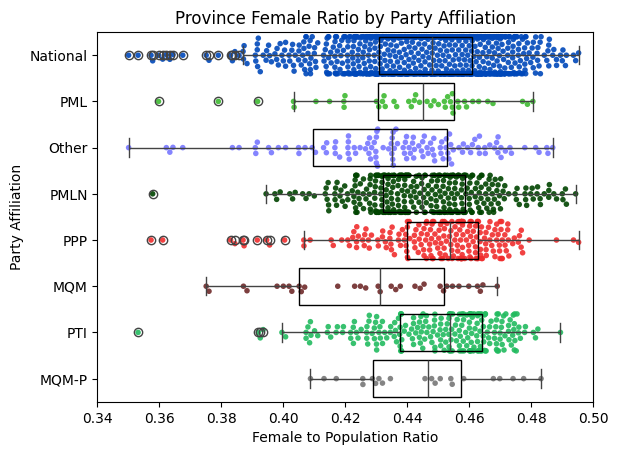

In [ ]:

swarm = sb.swarmplot(x='femaleRatio', y="party_affilation", data=combinedData, hue='party_affilation', size=4, zorder=1, palette=party_colors, alpha=.9) 
box = sb.boxplot(x='femaleRatio', y='party_affilation', data=combinedData,linewidth=1, boxprops=dict(facecolor='none', edgecolor='black'), zorder=2)
plt.xlim(left=.34, right=.5)

swarm.set_xlabel('Female to Population Ratio')  # Label for the x-axis
swarm.set_ylabel('Party Affiliation')  # Label for the y-axis
swarm.set_title('Province Female Ratio by Party Affiliation')  # Title of the plot




plt.savefig('femaleProport.png', format='png', dpi=300)
plt.show()
#print((partyAndGenderData))

/home/omniladder/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 32.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/omniladder/.local/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


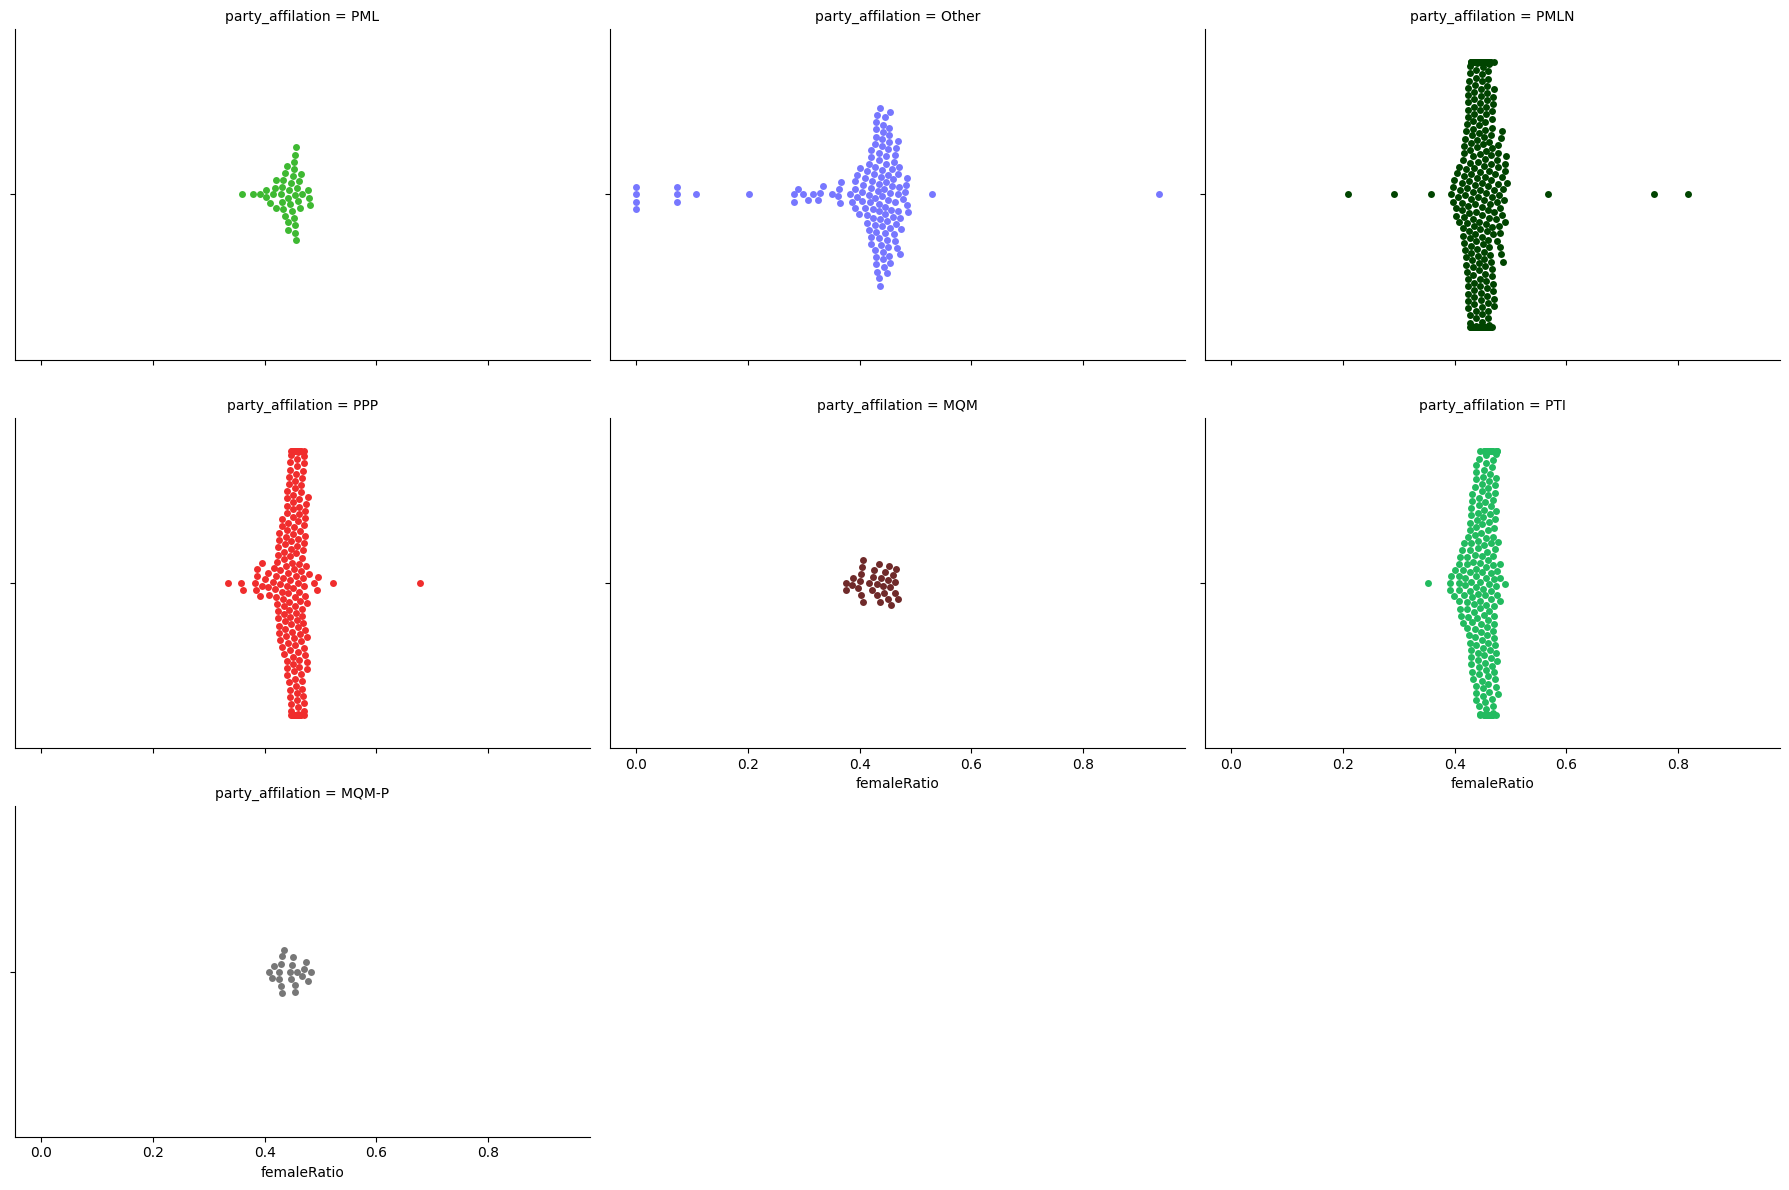

In [ ]:


# Define the palette
party_colors = {
    'PML': '#3EB932',
    'PMLN': '#004400',
    'PPP': '#F02D2D',
    'MQM': '#6F2A2A',
    'PTI': '#22BB5F',
    'MQM-P': '#777777',
    'Other': '#7777FF',
}

# Filter the data
combinedData = combinedData[combinedData['party_affilation'] != 'National']

# Create the FacetGrid for separate plots
g = sb.FacetGrid(combinedData, col="party_affilation",hue='party_affilation', col_wrap=3, height=4, aspect=1.5, palette=party_colors)

g.map(sb.swarmplot, "femaleRatio")


g.tight_layout()

plt.savefig('fullViewProport.png', format='png', dpi=300)

plt.show()

# Population Density

In [ ]:
party_colors = {
    'PML': '#3EB932',
    'PMLN': '#004400',
    'PPP': '#F02D2D',
    'MQM': '#6F2A2A',
    'PTI': '#22BB5F',
    'MQM-P': '#777777',
    'Other': '#7777FF'
}

popDensity = df.filter(items = ['party_affilation', 'pop', 'area'])

popScaler = StandardScaler()
areaScaler = StandardScaler()


X2 = sm.add_constant(popDensity['pop'])
est = sm.OLS(popDensity['area'], X2)
est2 = est.fit()
print(est2.summary())

colors = popDensity['party_affilation'].map(party_colors)
scaled_pop = popScaler.fit_transform(popDensity[['pop']])
scaled_area = areaScaler.fit_transform(popDensity[['area']])

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05791
Date:                Wed, 20 Nov 2024   Prob (F-statistic):              0.810
Time:                        00:27:12   Log-Likelihood:                -9937.4
No. Observations:                1009   AIC:                         1.988e+04
Df Residuals:                    1007   BIC:                         1.989e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2934.4702    497.502      5.898      0.0

Dummy Accuracy 0.4309895833333333
Accuracy: 0.57421875


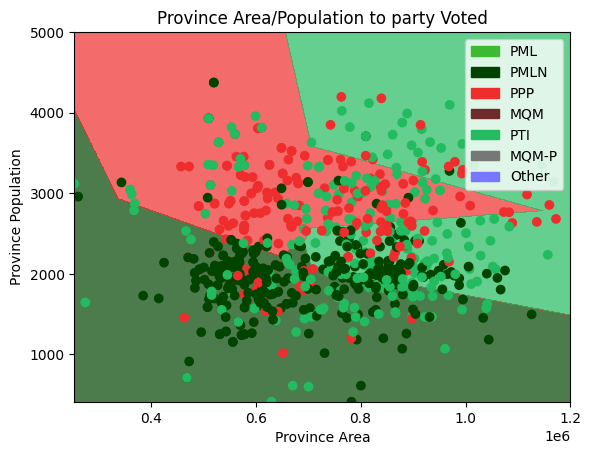

In [ ]:


popDensity = popDensity[popDensity['party_affilation'].isin(['PMLN', 'PPP', 'PTI'])]

colors = popDensity['party_affilation'].map(party_colors)
scaled_pop = popScaler.fit_transform(popDensity[['pop']])
scaled_area = areaScaler.fit_transform(popDensity[['area']])


#Grabs SVC and Draws Contour
svc = MLPClassifier(solver='lbfgs', alpha=1, hidden_layer_sizes=(5, 2), random_state=1)
dummy = DummyClassifier(strategy='most_frequent')

# Fit the model on the training data
dummy.fit(np.column_stack((scaled_pop, scaled_area)), popDensity['party_affilation'])

# Make predictions on the test set
y_pred = dummy.predict(np.column_stack((scaled_pop, scaled_area)))

# Calculate accuracy
accuracy = accuracy_score(popDensity['party_affilation'], y_pred)
print("Dummy Accuracy", accuracy)

# Encode categorical labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(popDensity['party_affilation'])

svc.fit(np.column_stack((scaled_pop, scaled_area)), y_encoded)



# Make predictions on the test data
y_pred = svc.predict(np.column_stack((scaled_pop, scaled_area)))

# Calculate the accuracy
accuracy = accuracy_score(y_encoded, y_pred)
print("Accuracy:",accuracy)



xx, yy = np.meshgrid(np.linspace(scaled_pop.min(), scaled_pop.max(), 10000), np.linspace(scaled_area.min(), scaled_area.max(), 10000))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

xx_original = popScaler.inverse_transform(xx.ravel().reshape(-1,1))  # Transform back to original scale
yy_original = areaScaler.inverse_transform(yy.ravel().reshape(-1,1))




cmap = ListedColormap([party_colors[party] for party in label_encoder.classes_])
levels = np.arange(len(label_encoder.classes_) + 1) - 0.5

#Z_colors = np.vectorize(lambda x: party_colors[label_encoder.inverse_transform(x)])(Z)


mask = ~np.isnan(Z)  # Create a mask for non-NaN values in Z

# Apply the mask to filter out NaNs from xx, yy, and Z
xx_original = xx_original[mask]
yy_original = yy_original[mask]
Z = Z[mask]

plt.contourf(xx_original.reshape(xx.shape), yy_original.reshape(yy.shape), Z.reshape(xx.shape),cmap=cmap, levels=levels , alpha = .7)



#plt.scatter(popDensity['pop'], popDensity['area'])

plt.title("Province Area/Population to party Voted")

plt.ylabel("Province Population")
plt.xlabel("Province Area")

plt.scatter(popDensity['pop'], popDensity['area'] , c=colors)

party_patches = [
    mpatches.Patch(color=color, label=party) 
    for party, color in party_colors.items()
]

plt.legend(handles=party_patches,loc=1)

plt.xlim(left=xx_original.min(), right=1.2e6)
plt.ylim(bottom=yy_original.min(), top=5000)

#plt.xlim(left=-1, right=1)
#plt.ylim(bottom=-1, top=1)

plt.savefig('popDensity.png', format='png', dpi=300)

plt.show()



# Geographical Dominance of Parties

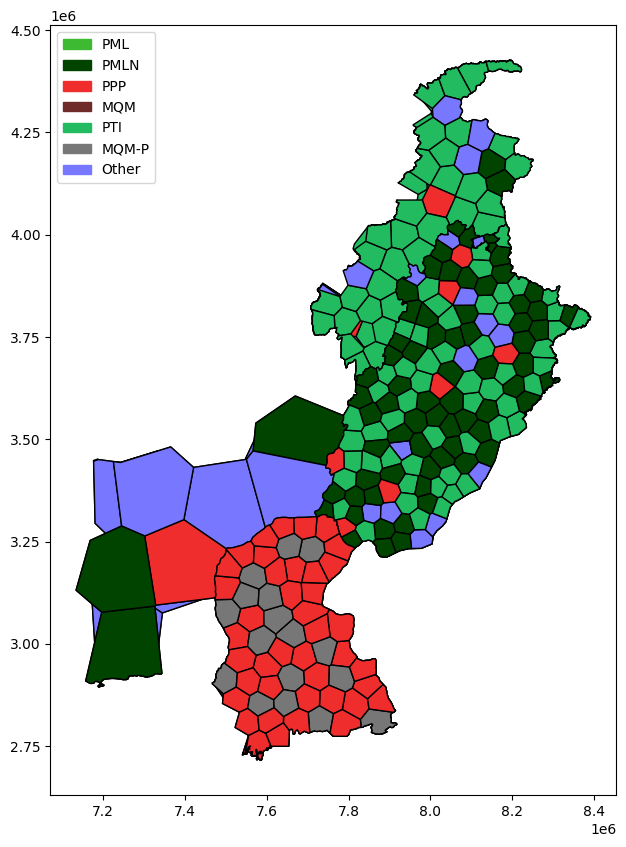

In [ ]:
pakiGeom = df.filter(items = ['party_affilation', 'geom'])

convertedGeom = []
# Loop through each GeoJSON in the DataFrame column
for geom in pakiGeom['geom']:
    try:
        # Parse the GeoJSON string into a geometry object
        geoJSON = json.loads(geom)
        geometry = shape(geoJSON)  # Convert the parsed GeoJSON into a Shapely geometry
        convertedGeom.append(geometry)
    except Exception as e:
        print(f"Error parsing GeoJSON: {e}")
        continue

# Create a GeoDataFrame from the list of geometries


gdf = gpd.GeoDataFrame(geometry=convertedGeom, crs="EPSG:4326")  

# Reproject to EPSG:3857 for compatibility with the basemap
gdf = gdf.to_crs(epsg=3857)


mappedColors = pakiGeom['party_affilation'].map(party_colors)

party_patches = [
    mpatches.Patch(color=color, label=party) 
    for party, color in party_colors.items()
]


fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=list(mappedColors), edgecolor='black')
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.legend(handles=party_patches,loc='upper left')


plt.savefig('pakistanMap.png', format='png', dpi=300)

Dummy Accuracy 0.3280475718533201
Accuracy: 0.5163528245787908


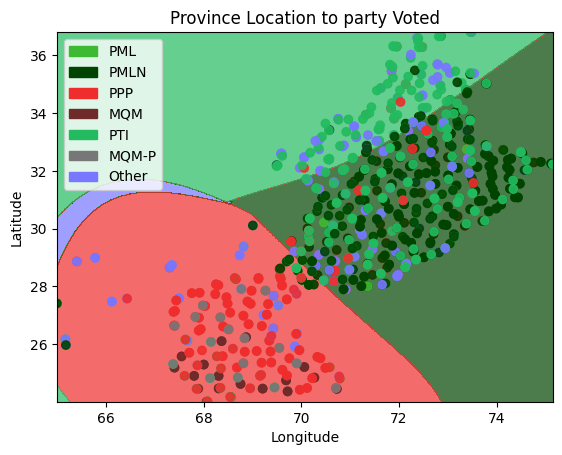

In [ ]:

locationParties = df.filter(['centerX', 'centerY', 'party_affilation'])

popScaler = StandardScaler()
areaScaler = StandardScaler()

colors = locationParties['party_affilation'].map(party_colors)
scaled_pop = popScaler.fit_transform(locationParties[['centerX']])
scaled_area = areaScaler.fit_transform(locationParties[['centerY']])

#Grabs SVC and Draws Contour
svc = SVC(kernel='rbf', C=0.05)
dummy = DummyClassifier(strategy='most_frequent')


plt.title("Province Location to party Voted")

plt.ylabel("Latitude")
plt.xlabel("Longitude")

# Encode categorical labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(locationParties['party_affilation'])

# Fit the model on the training data
dummy.fit(np.column_stack((scaled_pop, scaled_area)), locationParties['party_affilation'])

# Make predictions on the test set
y_pred = dummy.predict(np.column_stack((scaled_pop, scaled_area)))

# Calculate accuracy
accuracy = accuracy_score(locationParties['party_affilation'], y_pred)
print("Dummy Accuracy", accuracy)

# Calculate the accuracy


svc.fit(np.column_stack((scaled_pop, scaled_area)), y_encoded)


# Make predictions on the test data
y_pred = svc.predict(np.column_stack((scaled_pop, scaled_area)))
accuracy = accuracy_score(y_encoded, y_pred)
print("Accuracy:",accuracy)

xx, yy = np.meshgrid(np.linspace(scaled_pop.min(), scaled_pop.max(), 1000), np.linspace(scaled_area.min(), scaled_area.max(), 1000))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

xx_original = popScaler.inverse_transform(xx.ravel().reshape(-1,1))  # Transform back to original scale
yy_original = areaScaler.inverse_transform(yy.ravel().reshape(-1,1))


cmap = ListedColormap([party_colors[party] for party in label_encoder.classes_])
levels = np.arange(len(label_encoder.classes_) + 1) - 0.5

#Z_colors = np.vectorize(lambda x: party_colors[label_encoder.inverse_transform(x)])(Z)

plt.contourf(xx_original.reshape(xx.shape), yy_original.reshape(yy.shape), Z.reshape(xx.shape),cmap=cmap, levels=levels , alpha = .7)

party_patches = [
    mpatches.Patch(color=color, label=party) 
    for party, color in party_colors.items()
]

plt.legend(handles=party_patches,loc='best')

plt.scatter(locationParties['centerX'], locationParties['centerY'], label=locationParties['party_affilation'], c=locationParties['party_affilation'].map(party_colors),alpha=.9)

plt.savefig('locationGraph.png', format='png', dpi=300)

# Party Distibution Pakistan

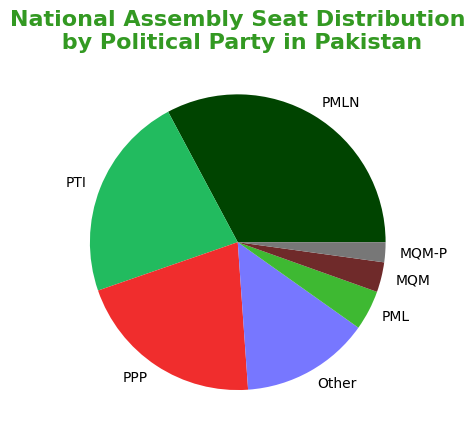

In [ ]:
#values, counts = np.unique(pakiParties, return_counts = True)


partyOccurences = df['party_affilation'].value_counts()


# Generate colors for the pie chart based on the order of parties in `partyOccurences`
colors = [party_colors[party] for party in partyOccurences.index]

plt.pie(partyOccurences.values, labels=partyOccurences.keys(), colors=colors)
plt.title('National Assembly Seat Distribution\n by Political Party in Pakistan', fontsize=16, fontweight='bold', color='#339922')

#plt.legend(bbox_to_anchor=(1,1.025), loc="upper left")


plt.savefig('vote_distribution.png', format='png', dpi=300)
plt.show()

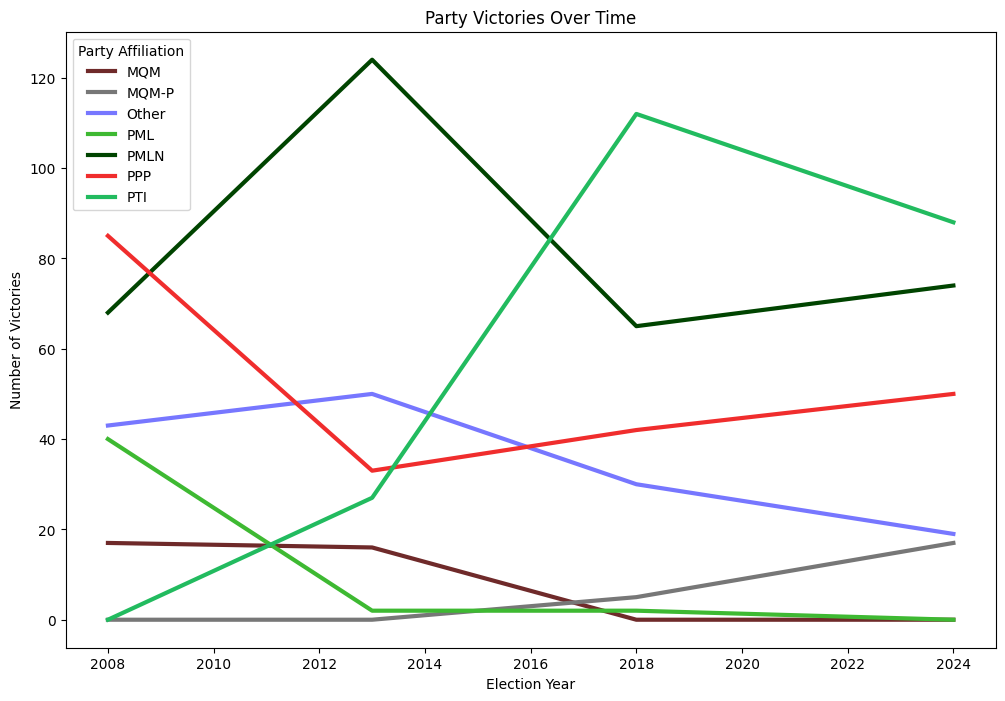

In [ ]:
victorsByYear = df.filter(['YEAR_ELECTION', 'party_affilation'])

party_counts = victorsByYear.groupby(['YEAR_ELECTION', 'party_affilation']).size().unstack(fill_value=0)

# Plot each party's occurrences as a line
fig, ax = plt.subplots(figsize=(12, 8))

party_colors_filtered = [party_colors[party] for party in party_counts.columns]

# Plot each party's occurrences as a line with custom colors
party_counts.plot(ax=ax, color=party_colors_filtered,linewidth=3)

# Add labels and title
plt.xlabel('Election Year')
plt.ylabel('Number of Victories')
plt.title('Party Victories Over Time')
plt.legend(title='Party Affiliation')

# Show plot
plt.savefig('victoriesOverTime.png', format='png', dpi=300)
plt.show()

# The Woman Vote Part 2

Index(['province', 'district', 'constituency_name', 'pop',
       'no_of_polling_stations', 'male', 'female', 'total', 'na_name',
       'obtained_votes', 'candidate_name', 'party_affilation', 'party', 'geom',
       'YEAR_ELECTION', 'femaleRatio', 'area', 'pop_density', 'centerX',
       'centerY', 'f_z_score', 'genderOutlier', 'femaleOutlier',
       'maleOutlier'],
      dtype='object')


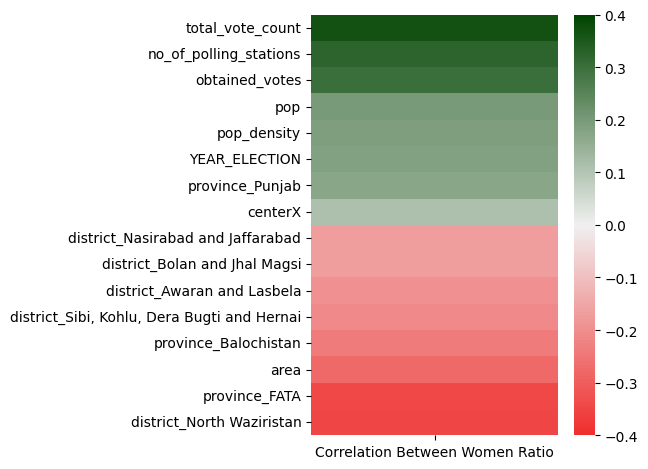

In [ ]:
print(df.columns)
femaleCoorData = df.drop(columns=['male', 'female', 'na_name', 'candidate_name', 'geom', 'constituency_name', 'party_affilation', 'party', 'femaleOutlier', 'genderOutlier', 'maleOutlier', 'f_z_score'])

# Create a dictionary to map the current column names to new ones
new_column_names = {'total': 'total_vote_count'}

# Rename the columns using the dictionary
femaleCoorData = femaleCoorData.rename(columns=new_column_names)

femaleCoorData = pd.get_dummies(femaleCoorData, drop_first=False)

fCorrelations = femaleCoorData.corr()['femaleRatio'].drop('femaleRatio')



# Get top 20 most positively and negatively correlated features
top_positive = fCorrelations.nlargest(8)
top_negative = fCorrelations.nsmallest(8)
top_negative = top_negative.iloc[::-1]
#fCorrelations = fCorrelations.to_frame(name='Correlation')
# Combine results

red = party_colors['PPP']   # Replace with your desired red
grey = "#F0F0F0"
green = party_colors['PMLN']  # Replace with your desired green

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("CustomRedGreen", [red, grey, green])


top_correlations = pd.concat([top_positive, top_negative])

sb.heatmap(top_correlations.to_frame(name='Correlation Between Women Ratio'), cmap=cmap, vmin=-.4, vmax=.4)
plt.tight_layout()
plt.savefig('femaleCoor.png', format='png', dpi=300)
plt.show()

      femaleRatio                                               geom na_name
0        0.477150  {"type":"Polygon","coordinates":[[[71.91123493...   NA-58
1        0.451065  {"type":"Polygon","coordinates":[[[71.42357862...   NA-72
2        0.456722  {"type":"Polygon","coordinates":[[[72.41638927...   NA-55
3        0.209171  {"type":"Polygon","coordinates":[[[74.55615662...  NA-118
4        0.431792  {"type":"Polygon","coordinates":[[[72.22323092...   NA-57
...           ...                                                ...     ...
1004     0.463607  {"type":"Polygon","coordinates":[[[68.24861983...  NA-221
1005     0.457411  {"type":"Polygon","coordinates":[[[70.25561122...  NA-214
1006     0.457935  {"type":"Polygon","coordinates":[[[69.25545308...  NA-215
1007     0.451834  {"type":"Polygon","coordinates":[[[68.61124300...  NA-225
1008     0.472349  {"type":"Polygon","coordinates":[[[67.90282198...  NA-213

[1009 rows x 3 columns]


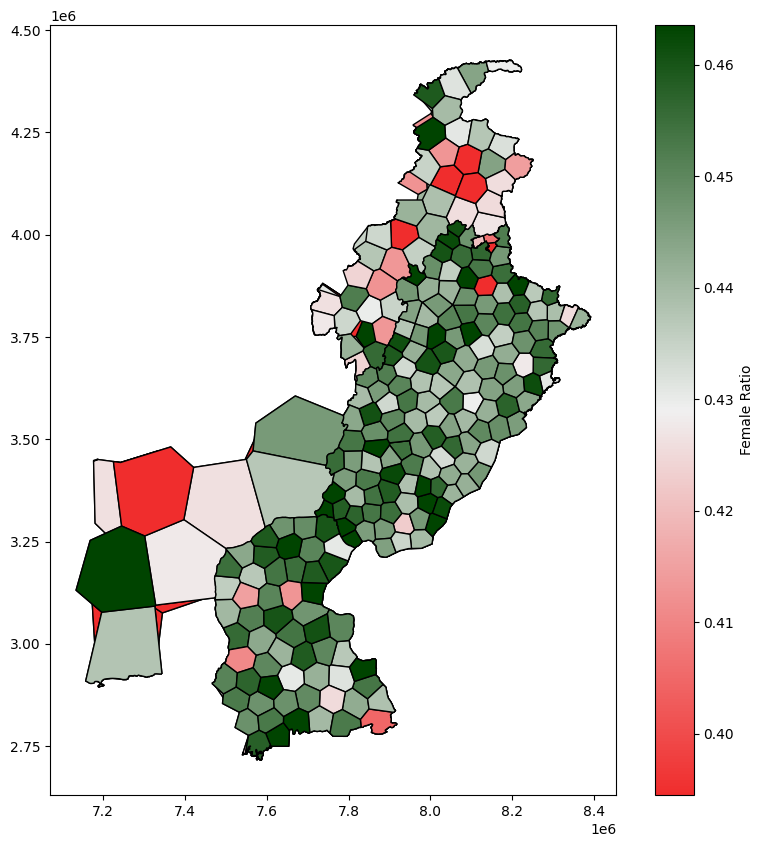

In [ ]:
pakiGeom = df.filter(items = ['femaleRatio', 'geom', 'na_name'])
ratioData = []
na_name = []

print(pakiGeom)

convertedGeom = []
# Loop through each GeoJSON in the DataFrame column
for index, geom in pakiGeom['geom'].items():
    try:
        # Parse the GeoJSON string into a geometry object
        geoJSON = json.loads(geom)
        geometry = shape(geoJSON)  # Convert the parsed GeoJSON into a Shapely geometry
        convertedGeom.append(geometry)
        ratioData.append(pakiGeom.loc[index, 'femaleRatio'])
        na_name.append(pakiGeom.loc[index, 'na_name'])
    except Exception as e:
        #print(f"Error parsing GeoJSON: {e}")
        continue

# Create a GeoDataFrame from the list of geometries


gdf = gpd.GeoDataFrame({'femaleRatio': ratioData, 'geometry': convertedGeom, 'na_name' : na_name}, geometry=convertedGeom, crs="EPSG:4326")  

# Reproject to EPSG:3857 for compatibility with the basemap
gdf = gdf.to_crs(epsg=3857)

# Calculate the mean femaleRatio for each province (na_name)
province_means = gdf.groupby('na_name')['femaleRatio'].mean().reset_index()

# Merge the mean values back into the original GeoDataFrame
gdf = gdf.merge(province_means, on='na_name', suffixes=('', '_mean'))

vmin = gdf['femaleRatio'].quantile(0.05)  # Minimum female ratio
vmax = gdf['femaleRatio'].quantile(0.8)


fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='femaleRatio_mean', ax=ax, edgecolor='black', cmap=cmap, vmin=vmin, vmax=vmax)
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
#ax.legend(handles=party_patches,loc='upper left')


scalemap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
scalemap.set_array([])  # Empty array, just for color bar

# Add the color bar on the side of the plot
cbar = fig.colorbar(scalemap, ax=ax, orientation='vertical', label='Female Ratio')
cbar.ax.tick_params(labelsize=10)

plt.savefig('womenMap.png', format='png', dpi=300)

Index(['province', 'district', 'constituency_name', 'pop',
       'no_of_polling_stations', 'male', 'female', 'total', 'na_name',
       'obtained_votes', 'candidate_name', 'party_affilation', 'party', 'geom',
       'YEAR_ELECTION', 'femaleRatio', 'area', 'pop_density', 'centerX',
       'centerY', 'f_z_score', 'genderOutlier', 'femaleOutlier',
       'maleOutlier'],
      dtype='object')


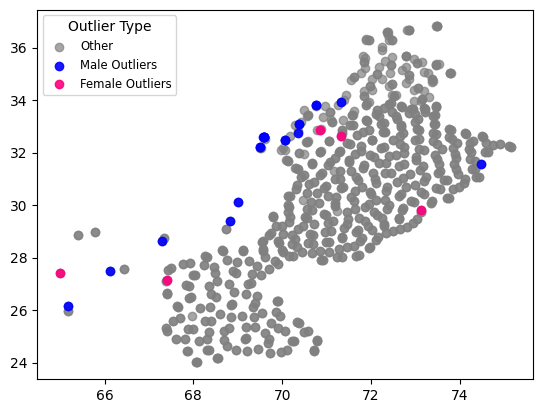

In [ ]:
print(df.columns)
pakiGeom = df.filter(items = ['genderOutlier', 'femaleOutlier', 'maleOutlier', 'centerX', 'centerY'])

not_outliers = pakiGeom[pakiGeom['genderOutlier'] == False]
female_outliers = pakiGeom[pakiGeom['femaleOutlier'] == True]
male_outliers = pakiGeom[pakiGeom['maleOutlier'] == True]

#TFColorMap = {True : party_colors['PMLN'], False : party_colors['PPP']}

plt.scatter(
    not_outliers['centerX'], not_outliers['centerY'], 
    color="#808080", alpha=0.7, label="Other"
)

# Plot male outliers on top (blue)
plt.scatter(
    male_outliers['centerX'], male_outliers['centerY'], 
    color="#0000FF", alpha=0.9, label="Male Outliers"
)

# Plot female outliers on top (pink)
plt.scatter(
    female_outliers['centerX'], female_outliers['centerY'], 
    color="#FF007F", alpha=0.9, label="Female Outliers"
)
plt.legend(title="Outlier Type", loc="best", fontsize="small", title_fontsize="medium")
#plt.scatter(pakiGeom_outliers['centerX'], pakiGeom_outliers['centerY'], label=pakiGeom_outliers['genderOutlier'], c=pakiGeom_outliers['genderOutlier'].map(TFColorMap),alpha=.7)

plt.savefig('outlierMap.png', format='png', dpi=300)

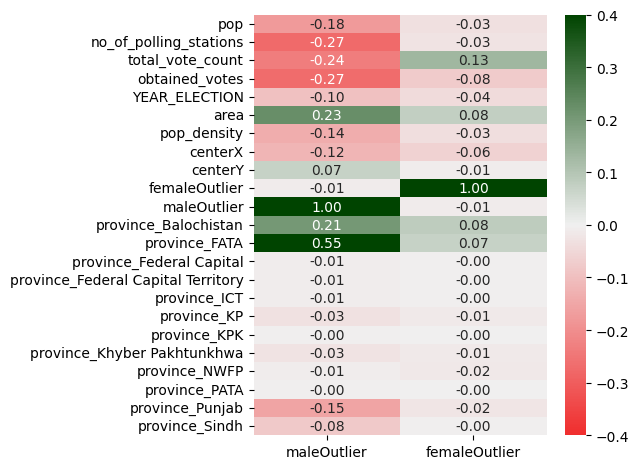

In [ ]:
outlierCoorData = df.drop(columns=['male', 'female', 'na_name', 'candidate_name', 'geom', 'constituency_name', 'party_affilation', 'party', 'femaleRatio', 'f_z_score', 'district', 'genderOutlier'])

# Rename columns using the dictionary
new_column_names = {'total': 'total_vote_count'}
outlierCoorData = outlierCoorData.rename(columns=new_column_names)

# Apply one-hot encoding to categorical variables
outlierCoorData = pd.get_dummies(outlierCoorData, drop_first=False)

# Calculate the correlation matrix
fCorrelations = outlierCoorData.corr()

# Extract correlations for 'maleOutlier', 'femaleOutlier', and 'genderOutlier'
outliers = ['maleOutlier', 'femaleOutlier']
correlations_outliers = fCorrelations[outliers]

# Define your custom colormap
red = party_colors['PPP']  # Replace with your desired red
grey = "#F0F0F0"
green = party_colors['PMLN']  # Replace with your desired green

cmap = LinearSegmentedColormap.from_list("CustomRedGreen", [red, grey, green])

# Create the heatmap using correlations of 'maleOutlier', 'femaleOutlier', and 'genderOutlier'
sb.heatmap(correlations_outliers, cmap=cmap, annot=True, fmt=".2f", cbar=True, vmin=-.4, vmax=.4)
plt.tight_layout()
# Tight layout and save the plot
#plt.tight_layout()
plt.savefig('outlierCorrelations.png', format='png', dpi=300)
plt.show()


Index(['province', 'district', 'constituency_name', 'pop',
       'no_of_polling_stations', 'male', 'female', 'total', 'na_name',
       'obtained_votes', 'candidate_name', 'party_affilation', 'party', 'geom',
       'YEAR_ELECTION', 'femaleRatio', 'area', 'pop_density', 'centerX',
       'centerY', 'f_z_score', 'genderOutlier', 'femaleOutlier',
       'maleOutlier'],
      dtype='object')
            pop                                           geometry
0      496142.0  POLYGON ((8005122.055 3958832.16, 8005118.331 ...
1      638480.0  POLYGON ((7950836.403 3896918, 7951054.421 389...
2      570886.0  POLYGON ((8061355.58 3944978.98, 8045282.872 3...
3      556480.0  POLYGON ((8299553.391 3736088.645, 8299541.41 ...
4      531585.0  POLYGON ((8039853.29 4000319.977, 8040128.188 ...
...         ...                                                ...
1004   726119.0  POLYGON ((7597401.607 2781751.146, 7581529.753...
1005   897087.0  POLYGON ((7820818.866 2967184.468, 7821568.579...
1006

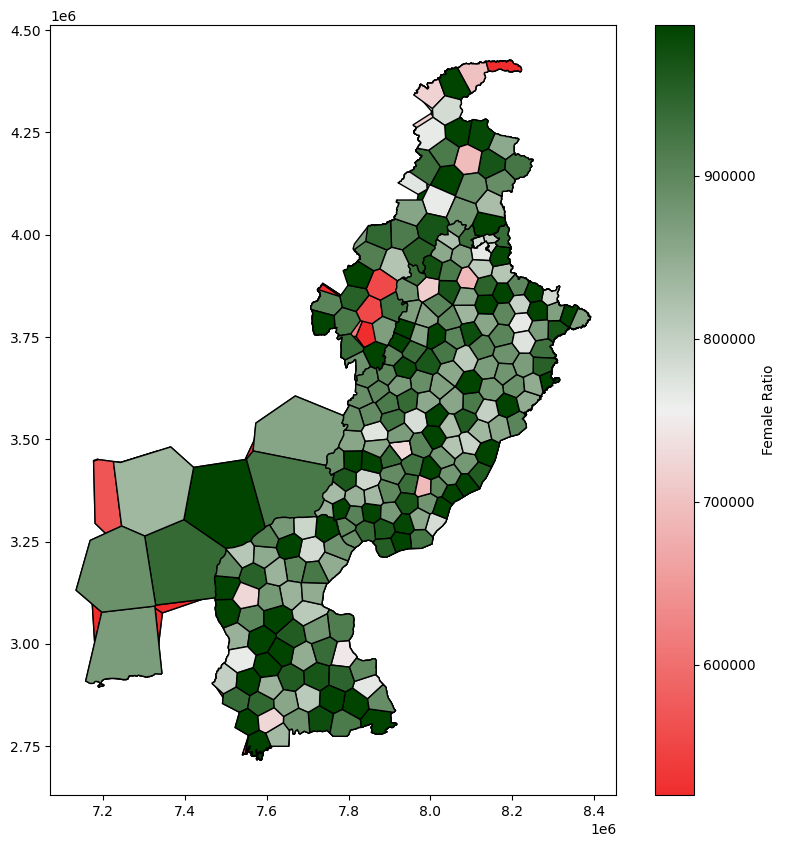

In [ ]:
print(df.columns)

pakiGeom = df.filter(items = ['pop', 'geom'])
ratioData = []


convertedGeom = []
# Loop through each GeoJSON in the DataFrame column
for index, geom in pakiGeom['geom'].items():
    try:
        # Parse the GeoJSON string into a geometry object
        geoJSON = json.loads(geom)
        geometry = shape(geoJSON)  # Convert the parsed GeoJSON into a Shapely geometry
        convertedGeom.append(geometry)
        ratioData.append(pakiGeom.loc[index, 'pop'])
    except Exception as e:
        #print(f"Error parsing GeoJSON: {e}")
        continue

# Create a GeoDataFrame from the list of geometries


gdf = gpd.GeoDataFrame({'pop': ratioData, 'geometry': convertedGeom}, geometry=convertedGeom, crs="EPSG:4326")  

# Reproject to EPSG:3857 for compatibility with the basemap
gdf = gdf.to_crs(epsg=3857)

print(gdf)

vmin = gdf['pop'].quantile(0.1)  # Minimum female ratio
vmax = gdf['pop'].quantile(.95)


fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='pop', ax=ax, edgecolor='black', cmap=cmap, vmin=vmin, vmax=vmax)
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
#ax.legend(handles=party_patches,loc='upper left')


scalemap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
scalemap.set_array([])  # Empty array, just for color bar

# Add the color bar on the side of the plot
cbar = fig.colorbar(scalemap, ax=ax, orientation='vertical', label='Female Ratio')
cbar.ax.tick_params(labelsize=10)

plt.savefig('PopulationMap.png', format='png', dpi=300)